In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import(
    GridSearchCV,
    train_test_split,
)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import(
    StandardScaler,
    OneHotEncoder,
)

# Loading Data

In [2]:
df = pd.read_csv("train.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Exploration and Data Preparation

### Examine Missing Values and Drop Low Information Columns

In [3]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
df.drop(
    columns=[
        "Cabin",
        "PassengerId",
        "Name",
        "Ticket",
    ],
    inplace=True,
)

### Convert The “Survived” Column to Our Target(y)

In [5]:
X = df.drop("Survived", axis=1)
y = df["Survived"].copy(deep=True)

### Train Test Split

In [6]:
X_train, X_test, y_train, y_test = (
    train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y,
    )
)

### Manipulate Data
* Fill Null Values
* Apply OneHot Encoding

In [8]:
age_imputer = SimpleImputer(strategy="median")
embarked_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot",  OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)
sex_ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ("age_imp", SimpleImputer(strategy="median"), ["Age"]),
        ("embarked_imp_ohe", embarked_pipeline, ["Embarked"]),
        ("sex_ohe", sex_ohe, ["Sex"]),
    ],
    remainder="passthrough"  
)

In [10]:
preprocessor.fit(X_train)

X_train_prepared = preprocessor.transform(X_train)
X_test_prepared  = preprocessor.transform(X_test)

In [11]:
age_cols = ["Age"]  
embarked_ohe_cols = (
    preprocessor
    .named_transformers_["embarked_imp_ohe"]
    .named_steps["onehot"]
    .get_feature_names_out(["Embarked"])
    .tolist()
)

In [12]:
sex_ohe_cols = (
    preprocessor
    .named_transformers_["sex_ohe"]
    .get_feature_names_out(["Sex"])
    .tolist()
)

### Recreate The Preprocessed DF

In [13]:
all_input_cols = X_train.columns.tolist()
passed_through = [
    col for col in all_input_cols
    if col not in ["Age", "Embarked", "Sex"]
]

In [14]:
feature_names = age_cols + embarked_ohe_cols + sex_ohe_cols + passed_through

In [18]:
X_train_df = pd.DataFrame(X_train_prepared, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_prepared,  columns=feature_names)

# add some features
X_train_df["Total_family"] = X_train_df['Parch'] + X_train_df['SibSp']
X_test_df["Total_family"] = X_test_df['Parch'] + X_test_df['SibSp']
X_train_df.drop(["Parch", "SibSp"], axis=1, inplace=True)
X_test_df.drop(["Parch", "SibSp"], axis=1, inplace=True)

### Standard‐Scale all Numeric Features

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

# Train MLP Model

### Create a Baseline MLP-Classifier With One Hidden Layer

In [23]:
mlp = MLPClassifier(
    hidden_layer_sizes=(50,),
    activation="relu",
    solver="adam",
    alpha=0.01,
    learning_rate_init=0.01,
    max_iter=200,
    random_state=42,
    verbose=False,
)

In [24]:
mlp.fit(X_train_scaled, y_train)

c:\Users\taha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.01,
              random_state=42)

In [25]:
y_pred = mlp.predict(X_test_scaled)

In [26]:
print(f"Baseline MLPClassifier Results:")
print(f"\nAccuracy: {accuracy_score(y_test, y_pred)}")
print(f"\n\n\Classification Reports:\n {classification_report(y_test, y_pred)}")
print(f"\n\n\nConfusion Matrix:\n {confusion_matrix(y_test, y_pred)}")

Baseline MLPClassifier Results:

Accuracy: 0.8100558659217877


\Classification Reports:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179




Confusion Matrix:
 [[97 13]
 [21 48]]


# Hyperparameter Tuning Via GridsearchCV

In [27]:
params_grid = {
    "hidden_layer_sizes": [
        (20,),
        (50,),
        (100,),
        (200,),
        (50, 30),
        (100, 50),
        (200, 50),
        (200, 100),
    ],
    "alpha": [
        1e-2,
        1e-3,
        1e-4
    ],
    "learning_rate_init": [
        1e-2,
        1e-3,
    ],
    "activation": [
        "relu",
        "tanh",
    ],
}

In [28]:
grid_search = GridSearchCV(
    estimator=MLPClassifier(
        solver="adam",
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=40,
        verbose=False,
    ),
    param_grid=params_grid,
    cv=5,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1,
)

In [29]:
print(">>> START GridSearchCV.....")
grid_search.fit(X_train_scaled, y_train)

>>> START GridSearchCV.....
Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=MLPClassifier(early_stopping=True, max_iter=1000,
                                     n_iter_no_change=40, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.01, 0.001, 0.0001],
                         'hidden_layer_sizes': [(20,), (50,), (100,), (200,),
                                                (50, 30), (100, 50), (200, 50),
                                                (200, 100)],
                         'learning_rate_init': [0.01, 0.001]},
             scoring='accuracy', verbose=2)

In [30]:
print(f"Best Params: {grid_search.best_params_}")
print(f"Best CV Accuracy: {grid_search.best_score_}")

Best Params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (200,), 'learning_rate_init': 0.01}
Best CV Accuracy: 0.8245346203092682


# Best Estimator on The Test Set

In [31]:
best_mlp = grid_search.best_estimator_
y_pred_best_model = best_mlp.predict(X_test_scaled)

In [32]:
print(f"Baseline MLPClassifier Results:")
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_best_model)}")
print(f"\n\n\Classification Reports:\n {classification_report(y_test, y_pred_best_model)}")
print(f"\n\n\nConfusion Matrix:\n {confusion_matrix(y_test, y_pred_best_model)}")

Baseline MLPClassifier Results:

Accuracy: 0.7821229050279329


\Classification Reports:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       110
           1       0.77      0.62      0.69        69

    accuracy                           0.78       179
   macro avg       0.78      0.75      0.76       179
weighted avg       0.78      0.78      0.78       179




Confusion Matrix:
 [[97 13]
 [26 43]]


# Learning Curve / Loss Curve Visualization

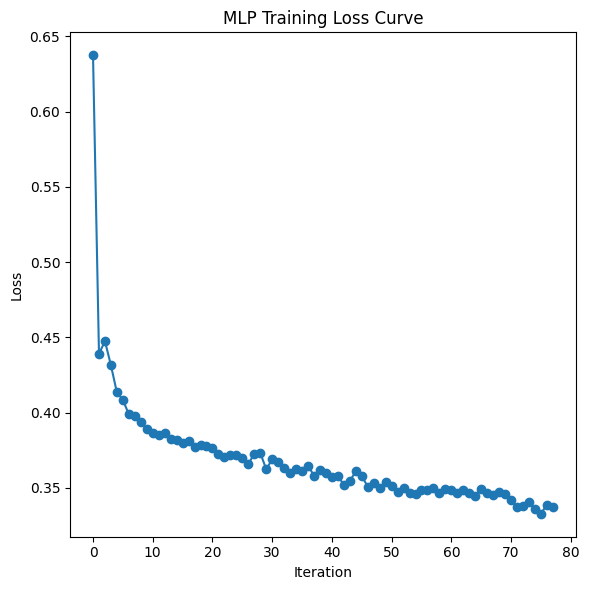

In [33]:
plt.figure(figsize=(6, 6))
plt.plot(best_mlp.loss_curve_, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("MLP Training Loss Curve")
plt.tight_layout()
plt.show()